## Filtering Outliers with Cook's Distance
Using low-pass filters is great for detecting outliers from a fitted linear regression model. 
An issue that can arise is a high-density grouping of outliers, which can skew the regression model.

One solution is to first build a model using cook's distance. One by one, every point in the linear regression model is removed, and the change in the model is noted. Each point is assigned a weight based on the change is the model.

### Set up cruise and data base files
Using standard methods, we will get the `stat` and `sfl` data frames stored inside the database 

In [1]:
library(popcycle)

cruise <- "SCOPE_1"
path <- "/Volumes/data/data/seaflow/refilter/"
#path <- "/Users/John/Documents/Armbrust/popcycle_project/"
db <- paste0(path,cruise, "/",cruise,".db")
stats <- get.stat.table(db, flag=F)
sfl <- get.sfl.table(db)

Loading required package: RSQLite
Loading required package: DBI
Loading required package: splancs
Loading required package: sp

Spatial Point Pattern Analysis Code in S-Plus
 
 Version 2 - Spatial and Space-Time analysis

Loading required package: plyr
Loading required package: uuid
Loading required package: tools


Next we will cast the `time` and `date` as POSIXct objects, and add a new column `flag` to the stats table. 

In [32]:
stats$time <- as.POSIXct(stats$time, format = "%FT%T", tz = "GMT")
stats$flag <- 0
sfl$date <- as.POSIXct(sfl$date, format = "%FT%T", tz = "GMT")

The flag column will keep track of what data gets filtered out as an outlier, and in what step it was filtered. As follows, a value of:

0: Not an outlier
1: Mechanical
2: Filtering
3: Gating

## Example of a poor fit

Using the standard method, we can see that no amount of "fiddling" with the `spar` parameter will allow you to flag the correct files. This is due to the highly scewed group of data at the beginning.

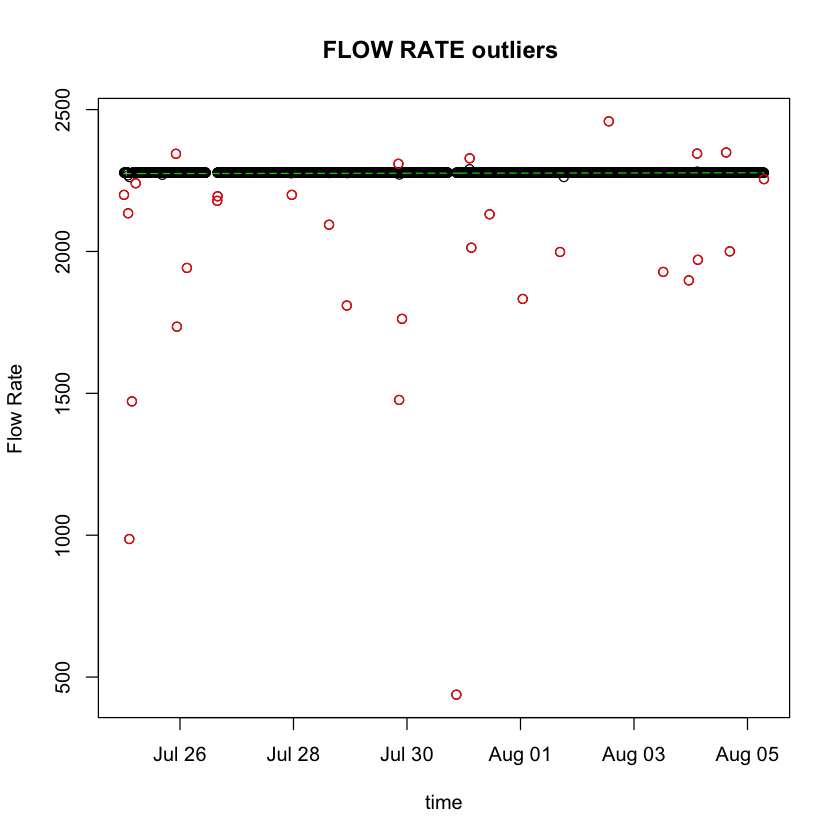

In [33]:
para <- "flow_rate"
plot(sfl[,"date"], sfl[,para],type="p", ylab="Flow Rate", xlab="time", main='FLOW RATE outliers ')
fact.sd <- 0.5
model <- smooth.spline(sfl[,"date"], sfl[,para], spar=1.9)
lines(sfl[,"date"], fitted(model),lty=2, col=3)
res <- residuals(model)
pre.out <- which(res < -fact.sd*sd(res) | res > fact.sd*sd(res))
id <- sfl[pre.out,"file"]; out <- which(!is.na(match(stats[,"file"], id)))
points(sfl[pre.out,"date"], sfl[pre.out,para], col=2)

## Let's look at the cook's distance on this data set
Building a linear regression model for the `flow_rate` and the `date` from the sfl table, we can look at the weights of the cook's distance of each file.

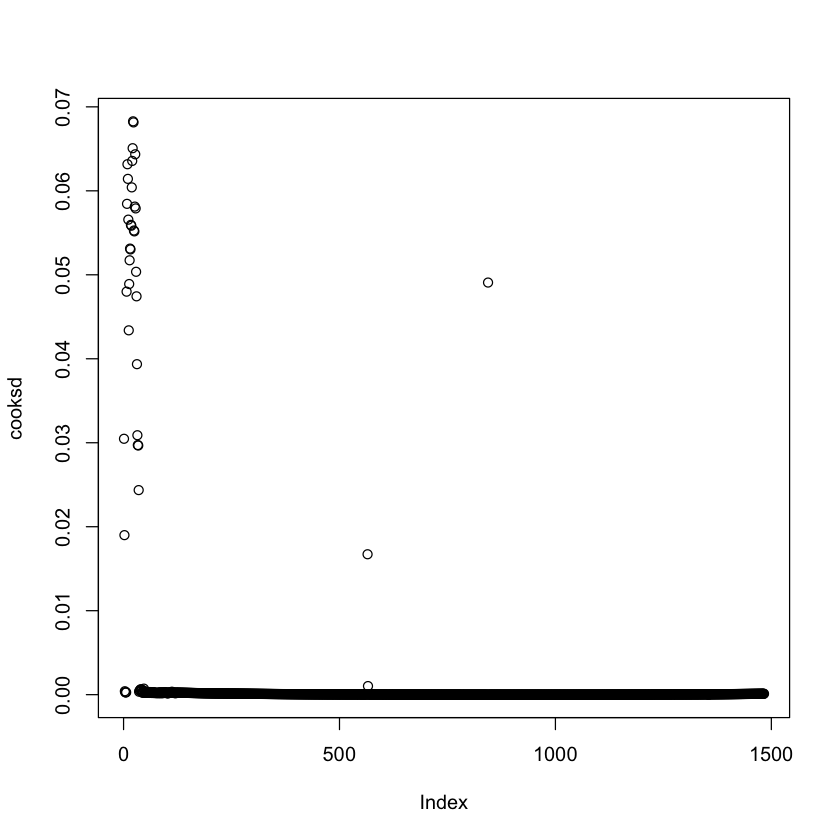

In [24]:
fit <- lm(flow_rate ~ date, data=sfl)
cooksd <- cooks.distance(fit)
plot(cooksd)

This shows that the first grouping of files was heavily weighted, thus skewing the results of the linear regression model. Let's look at the data points that are 4 standard deviations off of the mean weight, and remove them.

In [30]:
cooks.sfl <- as.numeric(names(cooksd)[(cooksd > 0.5*mean(cooksd, na.rm=T))])  # Influential files
cooks.sfl # This will display the file index of every file to remove
sfl.filtered <- sfl[-c(cooks.sfl),] # Filtered out the files

[1]   1   2   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
[20]  24  25  26  27  28  29  30  31  32  33  34  35  39  40  42  47 565 566 844

Now let's run the identical procedure as before, but with the filtered data.

ERROR: Error in eval(expr, envir, enclos): object 'stat' not found


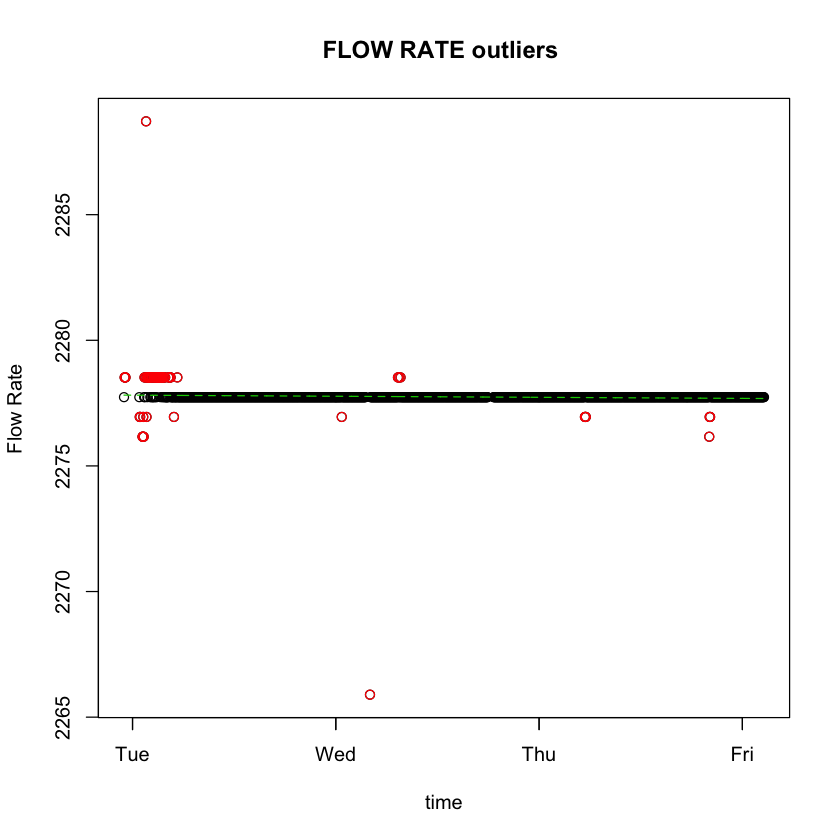

In [26]:
para <- "flow_rate"
plot(sfl.filtered[,"date"], sfl.filtered[,para],type="p", ylab="Flow Rate", xlab="time", main='FLOW RATE outliers ')
fact.sd <- 0.50
model <- smooth.spline(sfl.filtered[,"date"], sfl.filtered[,para], spar=1.75)
lines(sfl.filtered[,"date"], fitted(model),lty=2, col=3)
res <- residuals(model)
pre.out <- which(res < -fact.sd*sd(res) | res > fact.sd*sd(res))
id <- sfl.filtered[pre.out,"file"]; out <- which(!is.na(match(stats[,"file"], id)))
points(sfl.filtered[pre.out,"date"], sfl.filtered[pre.out,para], col=2)

stat[stat$flag]

We can see that not only were the files with a large cook's distance removed, but the linear regression model for the filtered data set is now much more accurate, and this time the correct files have been flagged.

## Different Cruises

In [21]:
cruise <- "SCOPE_6"
path <- "/Volumes/data/data/seaflow/refilter/"
#path <- "/Users/John/Documents/Armbrust/popcycle_project/"
db <- paste0(path,cruise, "/",cruise,".db")
stats <- get.stat.table(db, flag=F)
sfl <- get.sfl.table(db)
stats$time <- as.POSIXct(stats$time, format = "%FT%T", tz = "GMT")
stats$flag <- 0
sfl$date <- as.POSIXct(sfl$date, format = "%FT%T", tz = "GMT")

## Francois' method
opp/evt ratio

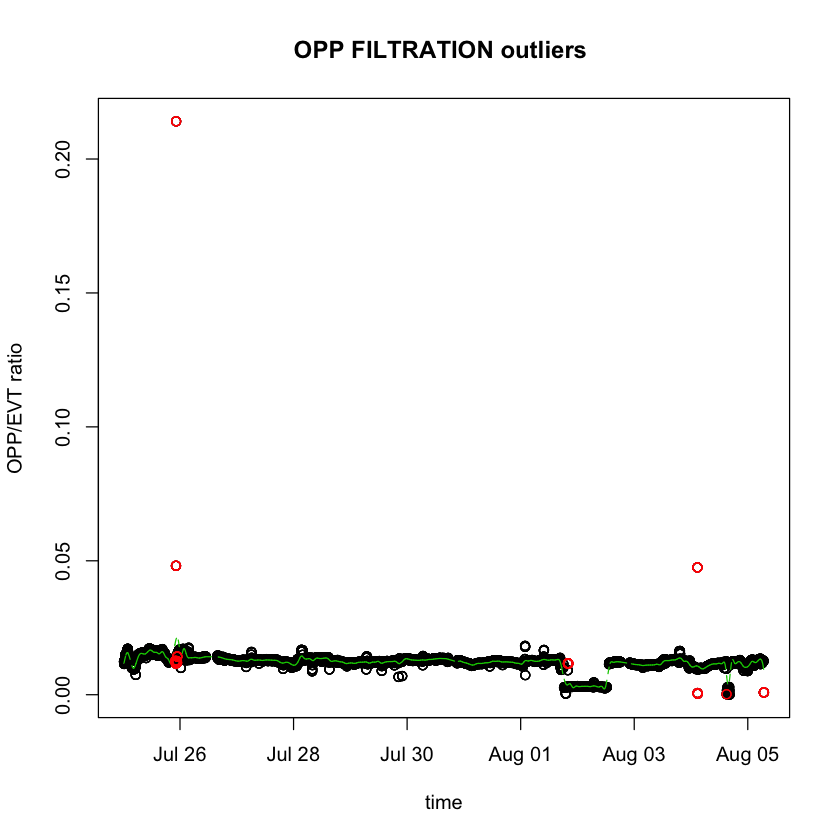

In [22]:
### remove OPP FILTRATION outliers
df <- subset(stats,flag==0)
para <- "opp_evt_ratio"
plot(df[,"time"], df[,para],type="p", ylab="OPP/EVT ratio", xlab="time", main='OPP FILTRATION outliers ')
fact.sd <- 2.5
model <- smooth.spline(df[,"time"], df[,para], spar=0.125)
lines(df[,"time"], fitted(model),lty=2, col=3)
res <- residuals(model)
out <- which(res < -fact.sd*sd(res) | res > fact.sd*sd(res))
#out <- which(df[,para] < 0.005)
points(df[out,"time"], df[out,para], col=2)

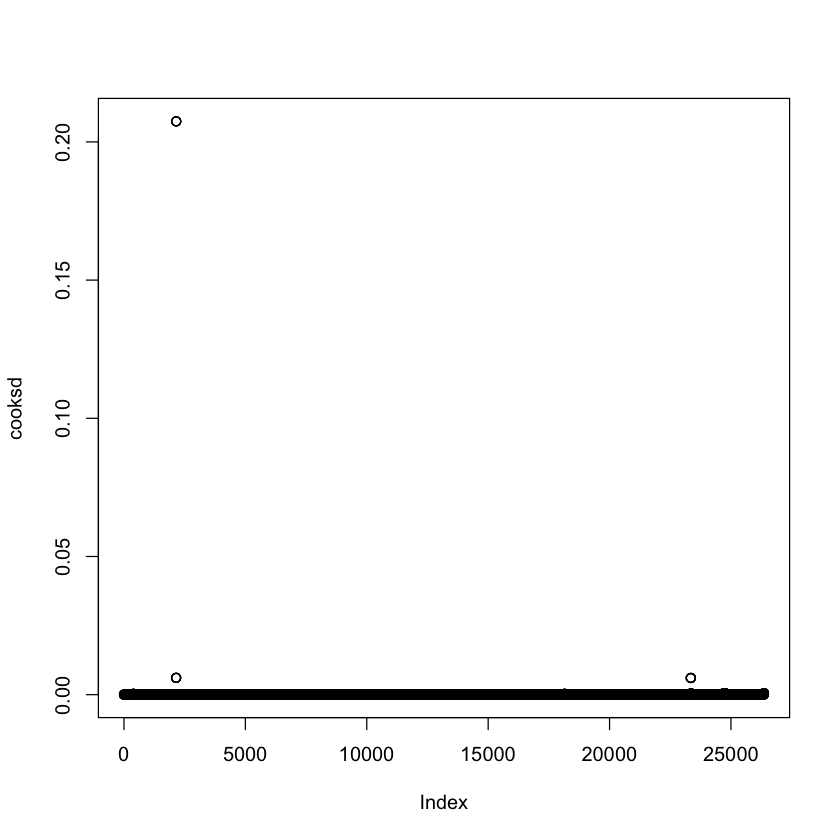

In [23]:
fit <- lm(opp_evt_ratio ~ time, data=stats)
cooksd <- cooks.distance(fit)
plot(cooksd)

In [24]:
cooks.stats <- as.numeric(names(cooksd)[(cooksd > 1000*mean(cooksd, na.rm=T))])  # Influential files
cooks.stats # This will display the file index of every file to remove
stats.filtered <- stats[-c(cooks.stats),] # Filtered out the files

[1] 2150 2151 2152 2153

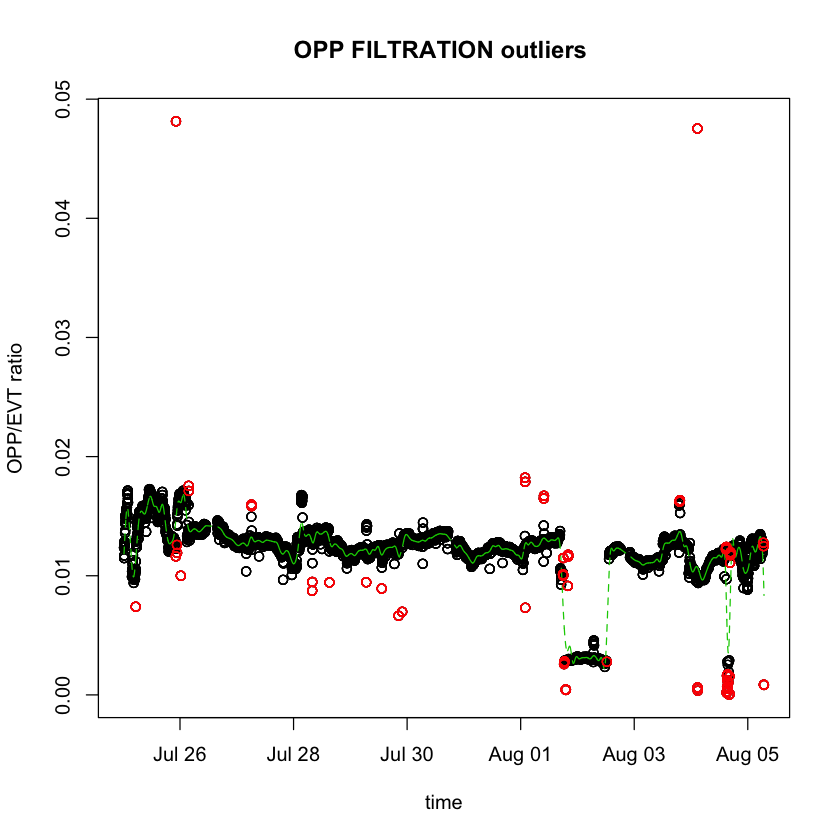

In [25]:
### remove OPP FILTRATION outliers
df <- subset(stats.filtered,flag==0)
para <- "opp_evt_ratio"
plot(df[,"time"], df[,para],type="p", ylab="OPP/EVT ratio", xlab="time", main='OPP FILTRATION outliers ')
fact.sd <- 2.5
model <- smooth.spline(df[,"time"], df[,para], spar=0.125)
lines(df[,"time"], fitted(model),lty=2, col=3)
res <- residuals(model)
out <- which(res < -fact.sd*sd(res) | res > fact.sd*sd(res))
#out <- which(df[,para] < 0.005)
points(df[out,"time"], df[out,para], col=2)

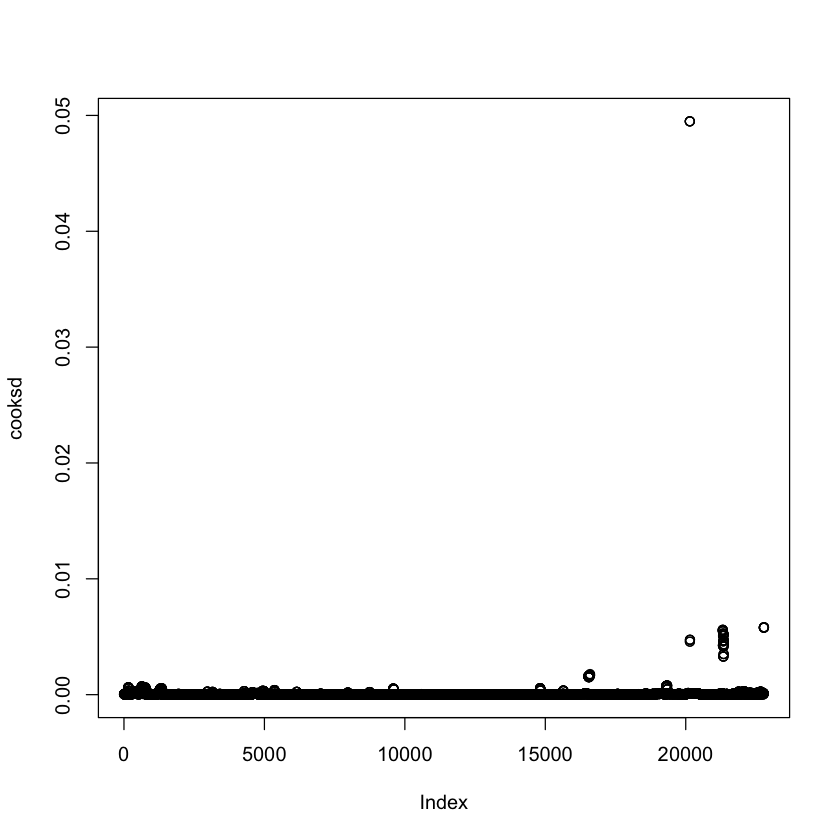

In [80]:
fit <- lm(opp_evt_ratio ~ time, data=stats.filtered)
cooksd <- cooks.distance(fit)
plot(cooksd)

In [77]:
cooks.stats <- as.numeric(names(cooksd)[(cooksd > 2*mean(cooksd, na.rm=T))])  # Influential files
cooks.stats # This will display the file index of every file to remove

[1]     1     2     3     4     5     6     7     8     9    10    11    12
  [13]    13    14    15    16    17    18    19    20    21    22    23    24
  [25]   127   128   129   130   131   132   151   152   153   154   155   156
  [37]   169   170   171   172   173   174   175   176   177   178   179   180
  [49]   181   182   183   184   185   186   187   188   189   190   191   192
  [61]   193   194   195   196   197   198   199   200   201   202   203   204
  [73]   205   206   207   208   209   210   231   232   233   234   241   242
  [85]   243   244   245   246   247   252   253   254   255   256   257   258
  [97]   259   264   265   266   267   268   269   270   271   272   273   274
 [109]   275   276   277   278   346   347   348   370   371   372   373   374
 [121]   375   376   377   378   379   380   381   382   383   384   385   386
 [133]   387   394   395   396   397   398   399   424   425   426   427   641
 [145]   642   643   644   645   646   647   648   649   650   651   652   653
 [157]   654   660   661   662   663   664   665   666   667   668   669   670
 [169]   671   672   679   680   681   682   694   695   696   697   698   717
 [181]   718   719   720   721   722   728   729   730   731   732   743   744
 [193]   745   746   747   759   760   761   762   763   764   845   846   847
 [205]   848   849   850   851   852   853   854   855   856   857   858   859
 [217]   860   861   862   869   870   871   872   873   874   875   876   877
 [229]   878   885   886   887   888   889   890   891   892   893   894   895
 [241]   896   897   898   899   900   901   902   903   904   905   906   913
 [253]   914   915   916   917   918   919   920   921   922   923   924   925
 [265]   926   927   928   929   930   931   932   933   934   935   936   937
 [277]   938   939   940   941   942   943   944   945   946   947   948   949
 [289]   950   951   952   953   954   955   956   957   958   959   960   961
 [301]   962   963   964   965   966   967   968   969   970   971   972   973
 [313]   974   975   976   977   978   979   980   981   982   983   984   985
 [325]   986   987   988   989   990   991   992   993   994   995   996   997
 [337]   998   999  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009
 [349]  1010  1011  1012  1013  1014  1015  1016  1017  1018  1019  1020  1021
 [361]  1022  1023  1024  1025  1026  1027  1028  1029  1030  1031  1032  1033
 [373]  1034  1035  1036  1037  1038  1039  1040  1041  1042  1043  1044  1045
 [385]  1046  1047  1048  1049  1050  1051  1052  1053  1054  1055  1056  1057
 [397]  1058  1059  1060  1061  1062  1063  1064  1065  1066  1067  1068  1069
 [409]  1070  1071  1072  1073  1074  1075  1076  1077  1078  1079  1080  1081
 [421]  1082  1083  1084  1085  1086  1087  1088  1089  1090  1091  1092  1093
 [433]  1094  1095  1096  1107  1108  1109  1110  1111  1112  1113  1114  1115
 [445]  1116  1117  1118  1119  1120  1121  1122  1123  1124  1125  1126  1127
 [457]  1128  1129  1130  1131  1132  1133  1134  1135  1136  1137  1138  1139
 [469]  1140  1141  1142  1143  1144  1145  1146  1147  1148  1149  1150  1151
 [481]  1152  1153  1154  1155  1156  1157  1158  1159  1160  1161  1162  1168
 [493]  1169  1170  1171  1172  1173  1174  1175  1176  1177  1178  1179  1180
 [505]  1181  1182  1183  1184  1185  1186  1187  1188  1189  1190  1191  1192
 [517]  1193  1194  1195  1196  1197  1198  1199  1200  1201  1202  1203  1204
 [529]  1205  1206  1207  1208  1214  1215  1216  1217  1218  1219  1220  1221
 [541]  1222  1223  1224  1225  1226  1227  1228  1229  1230  1231  1232  1233
 [553]  1234  1235  1236  1237  1238  1239  1240  1241  1242  1243  1244  1245
 [565]  1246  1247  1248  1249  1250  1251  1252  1253  1254  1255  1256  1257
 [577]  1258  1259  1260  1261  1262  1263  1264  1265  1266  1267  1268  1269
 [589]  1270  1271  1272  1273  1274  1275  1276  1277  1278  1279  1280  1281
 [601]  1282  1283  1284  1285  1286  1287  1288  128

In [78]:
stats.filtered <- stats.filtered[-c(cooks.stats),] # Filtered out the files

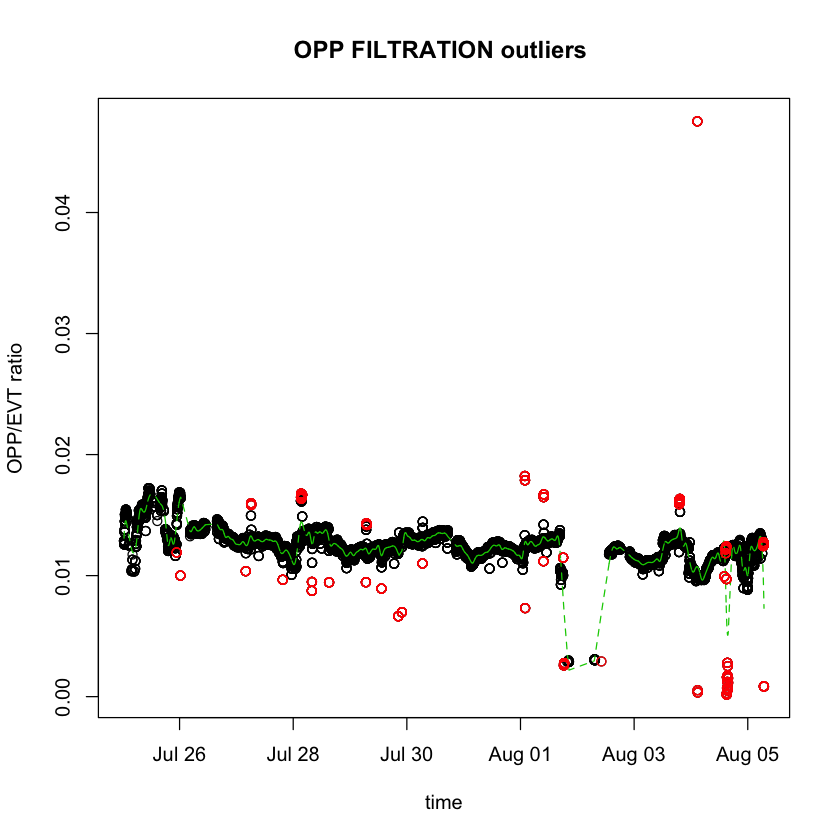

In [79]:
### remove OPP FILTRATION outliers
df <- subset(stats.filtered,flag==0)
para <- "opp_evt_ratio"
plot(df[,"time"], df[,para],type="p", ylab="OPP/EVT ratio", xlab="time", main='OPP FILTRATION outliers ')
fact.sd <- 2.5
model <- smooth.spline(df[,"time"], df[,para], spar=0.125)
lines(df[,"time"], fitted(model),lty=2, col=3)
res <- residuals(model)
out <- which(res < -fact.sd*sd(res) | res > fact.sd*sd(res))
#out <- which(df[,para] < 0.005)
points(df[out,"time"], df[out,para], col=2)